In [1]:
# ML_in_Finance-Autoencoders
# Author: Matthew Dixon
# Version: 1.0 (28.4.2020)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X running Python 3.6.9 with the following packages:
# tensorflow=2.0.0, keras=2.3.1, scikit-learn=0.22.1, numpy=1.18.1, matplotlib=3.1.3, pandas=1.0.3, seaborn=0.10.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and Halperin I., Machine Learning in Finance: From Theory to Practice, Springer Graduate Textbook Series, 2020. 

# Introduction

The purpose of this notebook is to first review PCA for yield curve dimension reduction. Linear autoencoders are then compared with PCA. Finally we evaluate deep autoencoders for yield curve compression.

# PCA
Principal component analysis requires finding the weights which maximize the maximum weighted variance of the data $Y$: 
$$\max_{w:||w||=1}Var(w^TY) = \max_{w:||w||=1}w^TVar(Y)w$$

Setting $w=v$, with $v$ the eigenvector corresponding to the largest eigenvalue $\lambda$ of $C:=Var(Y)$ will yield an orthogonal projection which is an optimal solution. From the eigenvalue problem, we can obtain the eigenvalues of $V$:

$$C v=\lambda v$$
$$(C-\lambda I)v=0$$
$$ |C-\lambda I|=0$$

Plugging the eigenvalues into second equation above gives the eigenvectors. The result can be written as:

$$\Lambda=V^TCV,$$

where $\Lambda$ is the diagonal matrix of descending eigenvalues and $P$ is the corresponding orthornormal matrix of eigenvectors. Rearanging gives the spectral decomposition of the covariance matrix.

$$C=P\Lambda P^T$$.

The transformation of Y onto the orthonormal basis spanned by the columns of $P$ is:
$$X=P^TY$$

# Libs & Defs

In [2]:
from keras.layers import Input, Dense
from keras import regularizers, models, optimizers

from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

Using TensorFlow backend.
/Users/Dez/anaconda3/envs/malfoy/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%matplotlib inline


We define a linear autoencoder model with Keras. The autoencoder tries to map the input data set back onto itself, via a reduced dimensionality representation in its single hidden layer. 

In training, the weights are therefore tuned to find a reduced set of features which retain as much as possible of the variance in the original dataset. 

In [4]:
def LinearAE(y, dimension, learning_rate = 1e-4, regularization = 1e-5, epochs=10):
    
    input_layer = Input(shape=(y.shape[1],))
    
    # the encoder layer transforms the input into a representation of size `dimension`
    encoder = Dense(dimension, activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(input_layer)
    
    # the decoder layer transforms the encoded representation back to the original size
    decoder = Dense(y.shape[1], activation='linear',
                    kernel_regularizer=regularizers.l2(regularization))(encoder)
    
    autoencoder = models.Model(input_layer, decoder)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    
    # the autoencoder aims to map the input back onto 
    # itself: the input data are also the output targets
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

# Load Dataset

In [5]:
df = pd.read_csv('../data/yield_curve.csv', sep=',')

df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

df.set_index('Date', drop=True, inplace=True)

df.index.names = [None]

df.drop('Index', axis=1, inplace=True)

n_obs = len(df)

##### Uncomment the `elif (...)` line to perform PCA on the daily yield changes $\Delta Y_0$:

In [6]:
if len(df) == n_obs - 1: print('differences already taken')
#elif len(df) == n_obs: df = df.diff(1).iloc[1:]

In [7]:
df.head()

,1M,2M,3M,6M,1Y,2Y,3Y,4Y,5Y,6Y,7Y,8Y,9Y,10Y
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


## Visualizing the Dataset

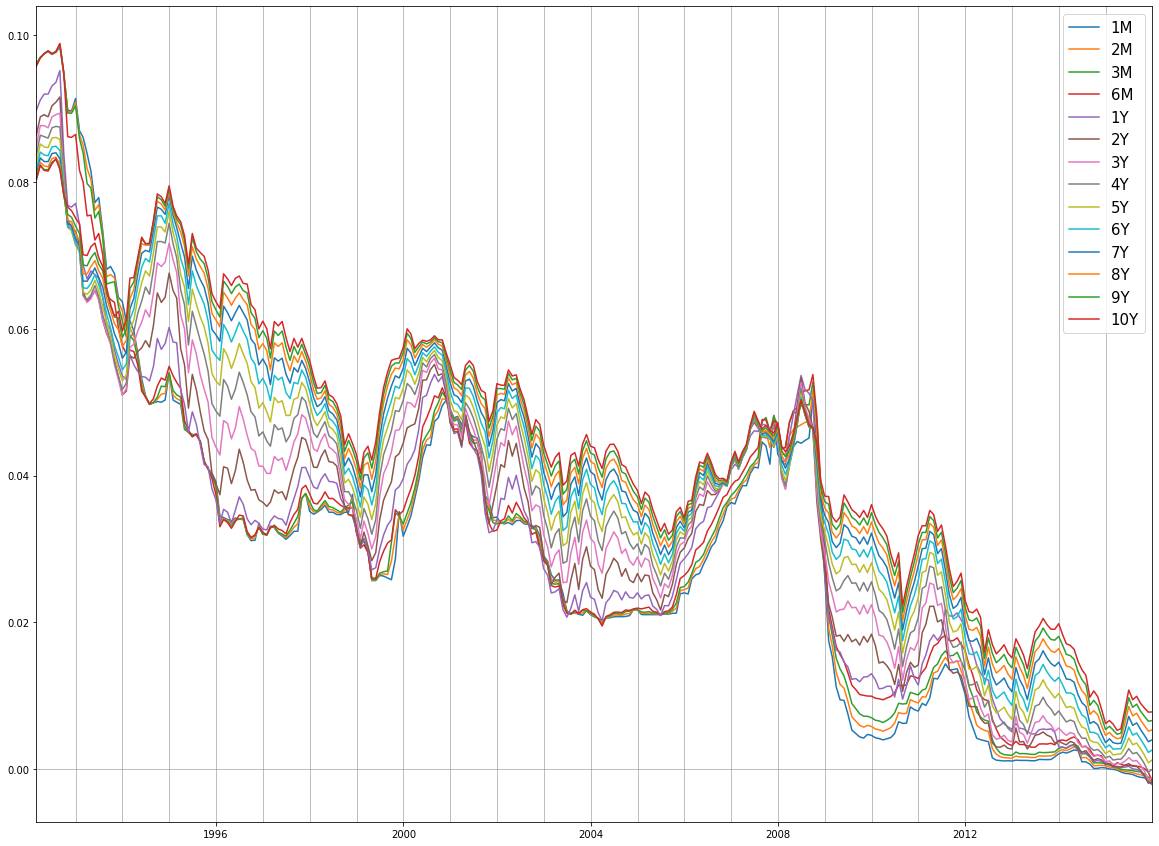

In [8]:
plt.figure(figsize=(20, 15))

plt.plot(df.index, df)

plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
plt.legend(df.columns, fontsize=15)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=datetime(i, 1, 1), c="grey", linewidth=0.5, zorder=0)

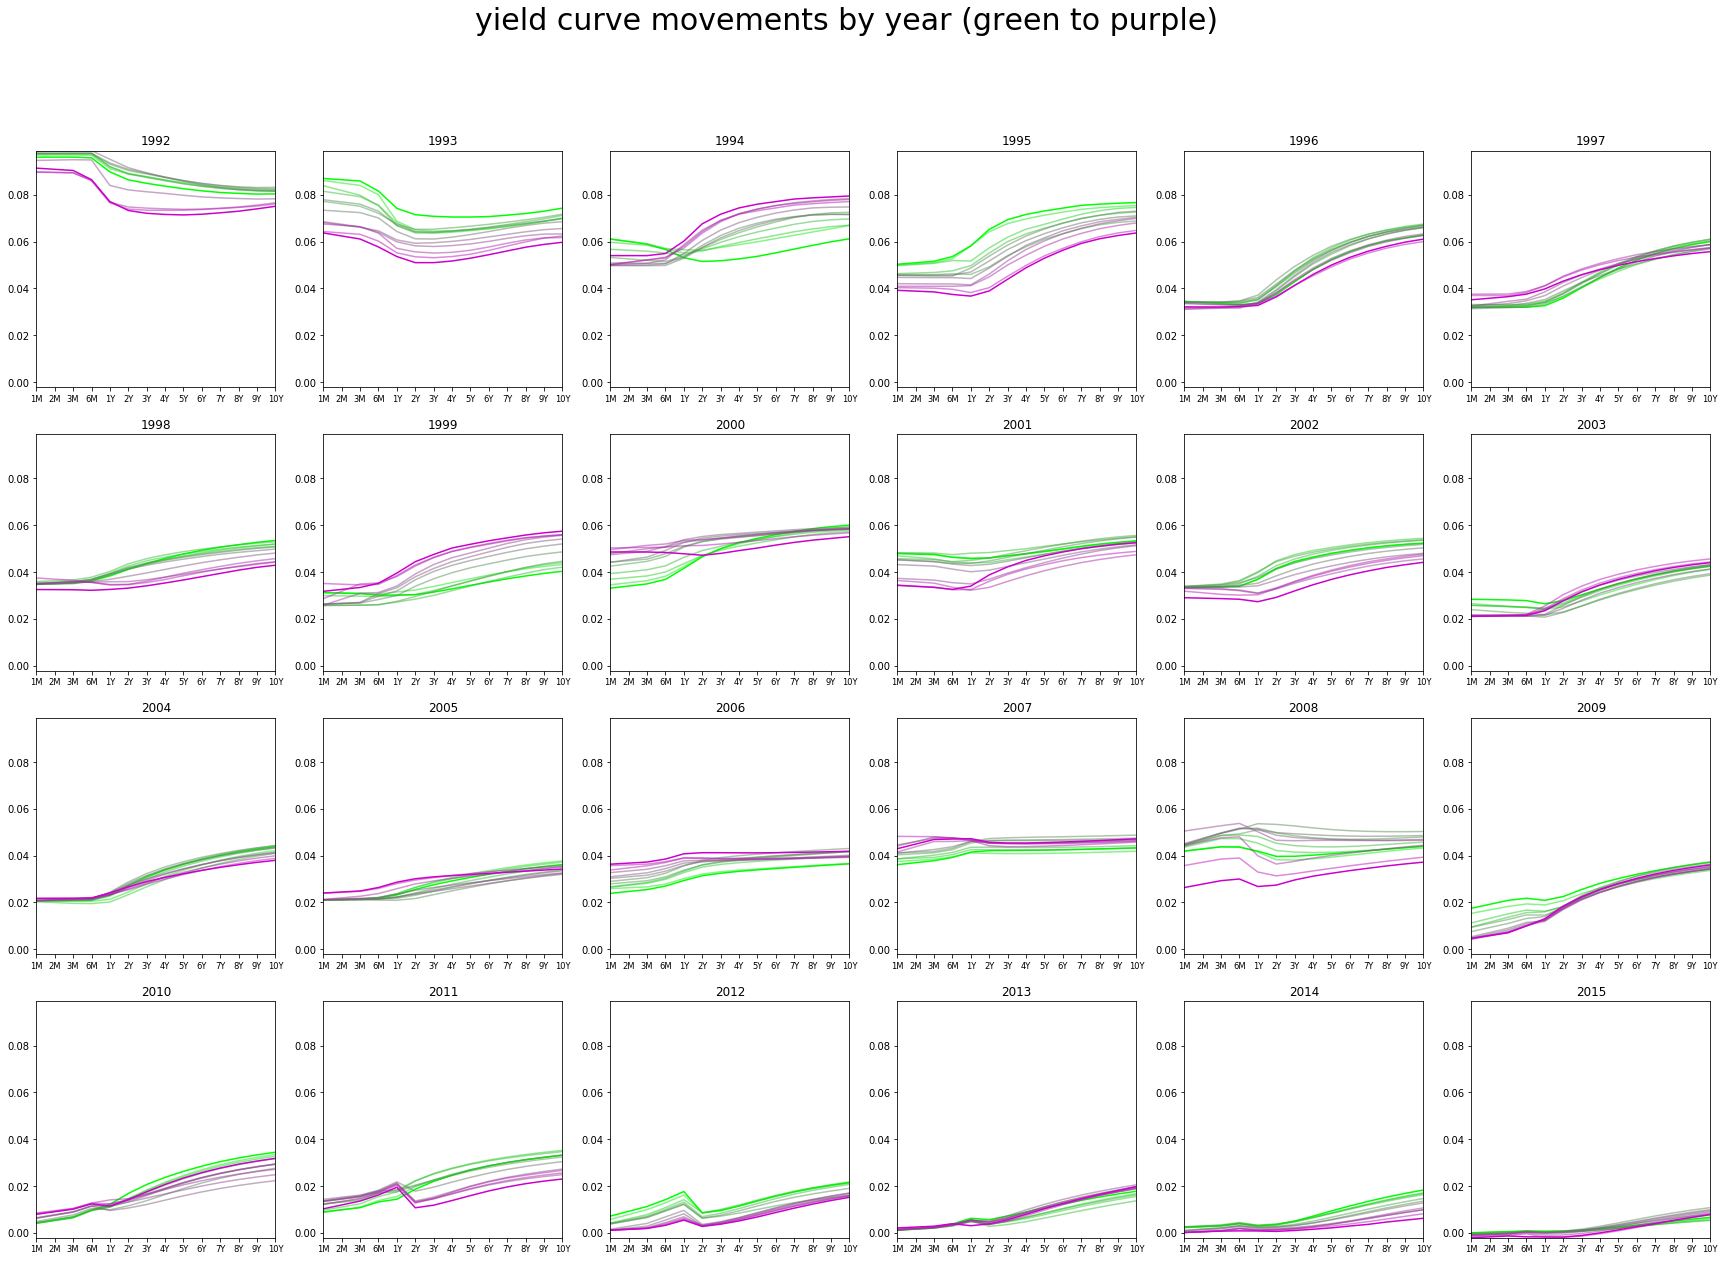

In [9]:
cols = 6
num_years = df.index.max().year - df.index.min().year
rows = int(np.ceil(num_years/cols))

# each line is a yield curve at a given time; each year begins green and ends purple
plt.figure(figsize=(30, (30/cols)*rows))
plt.suptitle('yield curve movements by year (green to purple)', fontsize=30)

colnum = 0
rownum = 0
for year in range(df.index.min().year, df.index.max().year+1):
    year_start = datetime(year, 1, 1)
    year_end = datetime(year, 12, 31)
    
    plt.subplot2grid((rows, cols), (rownum, colnum), colspan=1, rowspan=1)
    plt.title('{0}'.format(year))
    plt.xlim(0, len(df.columns)-1)
    plt.ylim(np.min(df.values), np.max(df.values))
    plt.xticks(range(len(df.columns)), df.columns, size='small')
    
    year_curves = df.loc[year_start:year_end].values    
    gradient = np.linspace([0, 1, 0, 1], [0.8, 0, 0.8, 1], year_curves.shape[0])
    gradient[1:-1, -1] = 0.5
    
    for yield_curve, colour in zip(year_curves, gradient):
        plt.plot(yield_curve, c=colour)

    if colnum != cols-1:
        colnum += 1
    else:
        colnum = 0
        rownum += 1

# Projection onto Principal Components

In [10]:
# calculate the first three PCs (Eigenvectors & Eigenvalues of the covariance matrix)
pca_model = PCA(n_components=3, copy=True, whiten=False)
pca_model.fit(df)

# project the dataset onto the principal components
df_pca = pd.DataFrame(pca_model.transform(df), index=df.index)

# transform the projections back into the input space
df_pca_recon = pd.DataFrame(pca_model.inverse_transform(df_pca), index=df.index, columns=df.columns)

In [11]:
df_pca.head()

,0,1,2
1992-02-29,0.189681,0.031657,-0.002092
1992-03-31,0.196655,0.029239,-0.003471
1992-04-30,0.196720,0.031033,-0.003950
1992-05-31,0.196820,0.031674,-0.003434
1992-06-30,0.199527,0.029321,-0.005054


## Plot the reconstruction error per variable for PCA

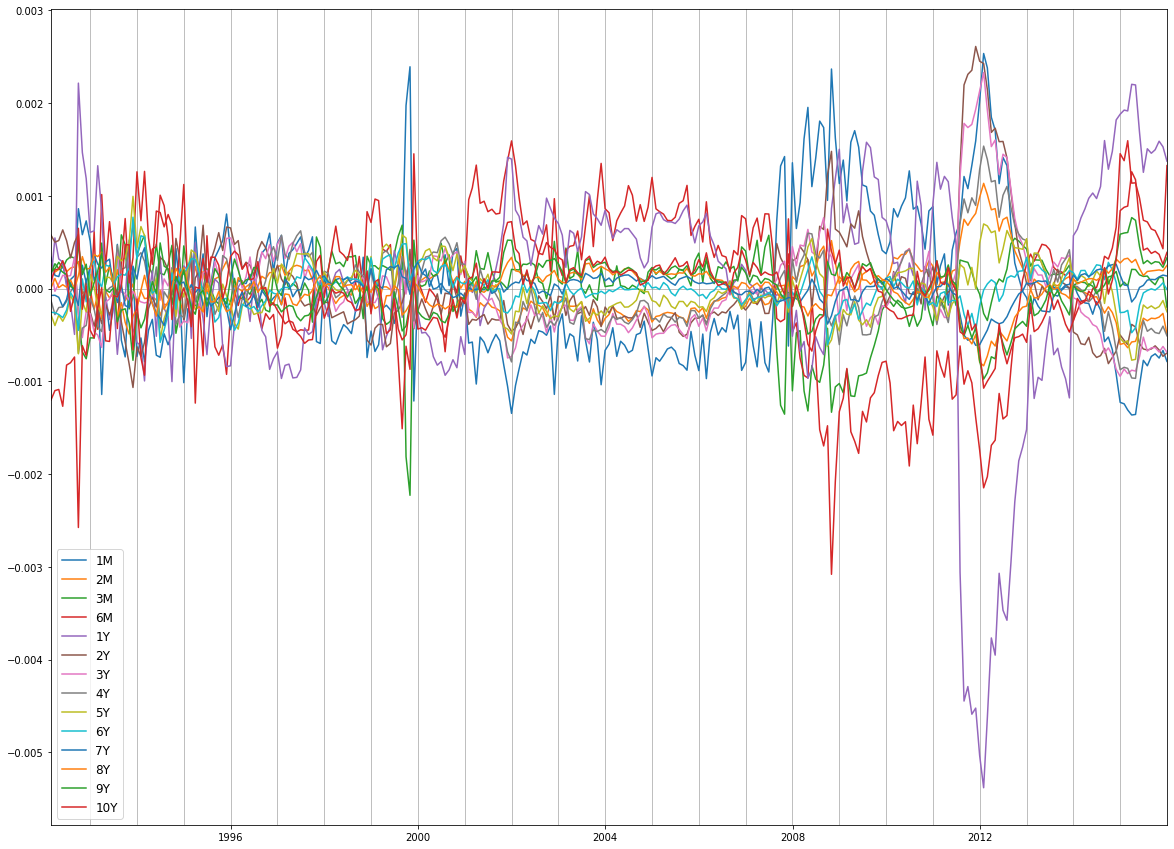

In [12]:
plt.figure(figsize=(20,15))

# Plotting the difference between the reconstructed value and the original
plt.plot(df.index, df_pca_recon-df.values)
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

### Evaluate the amount of variance explained by each component

In [13]:
for i, pc in enumerate(pca_model.explained_variance_ratio_):
    print('PC {0}:\t{1:5.2f}%'.format(i+1, pc*100.0))

PC 1:	95.53%
PC 2:	 4.07%
PC 3:	 0.33%


### Plot the loading vectors

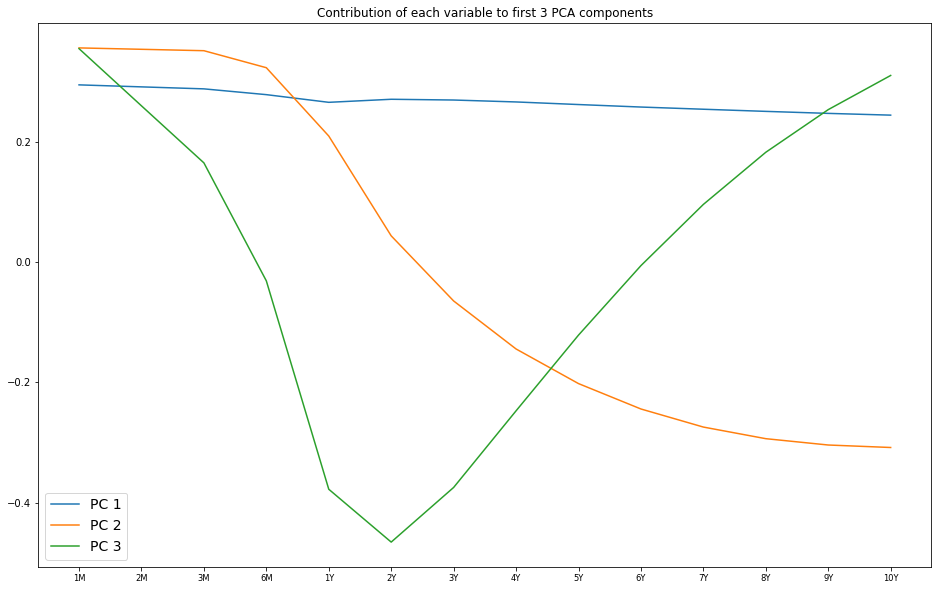

In [14]:
fig = plt.figure(figsize=(16,10))
plt.title('Contribution of each variable to first {0} PCA components'.format(pca_model.n_components))

plt.plot(np.transpose(pca_model.components_[0]), label='PC 1')
plt.plot(np.transpose(pca_model.components_[1]), label='PC 2')
plt.plot(np.transpose(pca_model.components_[2]), label='PC 3')
plt.xticks(range(len(df.columns)), df.columns, size='small')

plt.legend(fontsize=14);

From the graph it can be seen that, roughly speaking, the PCA representation encodes the yield curves' shapes in terms of their "height" (PC 1), "slope" (PC 2), and "V-shaped-ness" (PC 3)

# Linear Autoencoders

### Fit the linear auto-encoder

In [15]:
ae_model = LinearAE(df.values, 3, regularization=0, epochs=300)
(w1, b1, w2, b2) = ae_model.get_weights()

Epoch 1/300
287/287 [==============================] - 1s 5ms/step - loss: 0.0029
Epoch 2/300
287/287 [==============================] - 0s 1ms/step - loss: 0.0020
Epoch 3/300
287/287 [==============================] - 0s 816us/step - loss: 0.0014
Epoch 4/300
287/287 [==============================] - 0s 1ms/step - loss: 0.0010
Epoch 5/300
287/287 [==============================] - 1s 3ms/step - loss: 7.9052e-04
Epoch 6/300
287/287 [==============================] - 1s 2ms/step - loss: 6.5761e-04
Epoch 7/300
287/287 [==============================] - 0s 970us/step - loss: 5.7827e-04
Epoch 8/300
287/287 [==============================] - 0s 633us/step - loss: 5.3053e-04
Epoch 9/300
287/287 [==============================] - 0s 859us/step - loss: 5.0032e-04
Epoch 10/300
287/287 [==============================] - 1s 2ms/step - loss: 4.7919e-04
Epoch 11/300
287/287 [==============================] - 0s 1ms/step - loss: 4.6394e-04
Epoch 12/300
287/287 [==============================] - 1s 2

Epoch 94/300
287/287 [==============================] - 0s 662us/step - loss: 2.0741e-05
Epoch 95/300
287/287 [==============================] - 0s 682us/step - loss: 2.0556e-05
Epoch 96/300
287/287 [==============================] - 0s 592us/step - loss: 2.0254e-05
Epoch 97/300
287/287 [==============================] - 0s 622us/step - loss: 2.0090e-05
Epoch 98/300
287/287 [==============================] - 0s 626us/step - loss: 1.9957e-05
Epoch 99/300
287/287 [==============================] - 0s 602us/step - loss: 1.9866e-05
Epoch 100/300
287/287 [==============================] - 0s 595us/step - loss: 1.9665e-05
Epoch 101/300
287/287 [==============================] - 0s 1ms/step - loss: 1.9421e-05
Epoch 102/300
287/287 [==============================] - 0s 592us/step - loss: 1.9215e-05
Epoch 103/300
287/287 [==============================] - 0s 620us/step - loss: 1.9143e-05
Epoch 104/300
287/287 [==============================] - 0s 811us/step - loss: 1.9185e-05
Epoch 105/300
287/

287/287 [==============================] - 0s 625us/step - loss: 1.3443e-05
Epoch 186/300
287/287 [==============================] - 0s 605us/step - loss: 1.3410e-05
Epoch 187/300
287/287 [==============================] - 0s 606us/step - loss: 1.3342e-05
Epoch 188/300
287/287 [==============================] - 0s 594us/step - loss: 1.3222e-05
Epoch 189/300
287/287 [==============================] - 0s 619us/step - loss: 1.3234e-05
Epoch 190/300
287/287 [==============================] - 0s 601us/step - loss: 1.3140e-05
Epoch 191/300
287/287 [==============================] - 0s 647us/step - loss: 1.3187e-05
Epoch 192/300
287/287 [==============================] - 0s 600us/step - loss: 1.3118e-05
Epoch 193/300
287/287 [==============================] - 0s 605us/step - loss: 1.3068e-05
Epoch 194/300
287/287 [==============================] - 0s 632us/step - loss: 1.2988e-05
Epoch 195/300
287/287 [==============================] - 0s 591us/step - loss: 1.2987e-05
Epoch 196/300
287/287 [=

287/287 [==============================] - 0s 2ms/step - loss: 9.1131e-06
Epoch 277/300
287/287 [==============================] - 0s 2ms/step - loss: 9.0348e-06
Epoch 278/300
287/287 [==============================] - 0s 1ms/step - loss: 8.9846e-06
Epoch 279/300
287/287 [==============================] - 0s 943us/step - loss: 8.9528e-06
Epoch 280/300
287/287 [==============================] - 0s 650us/step - loss: 8.8859e-06
Epoch 281/300
287/287 [==============================] - 0s 651us/step - loss: 8.8017e-06
Epoch 282/300
287/287 [==============================] - 0s 691us/step - loss: 8.7643e-06
Epoch 283/300
287/287 [==============================] - 0s 802us/step - loss: 8.7034e-06
Epoch 284/300
287/287 [==============================] - 0s 644us/step - loss: 8.6998e-06
Epoch 285/300
287/287 [==============================] - 0s 891us/step - loss: 8.6326e-06
Epoch 286/300
287/287 [==============================] - 0s 1ms/step - loss: 8.5909e-06
Epoch 287/300
287/287 [=========

### Extract the left singular vectors of the decoder weight matrix

In [16]:
(ae_decoder_lsv, _, _) = np.linalg.svd(w2.T, full_matrices=False)

In [17]:
mu = np.mean(df.values, axis=0)
ae_lsv_projections = np.array(df.values-mu) @ ae_decoder_lsv

In [18]:
df_ae = pd.DataFrame(ae_lsv_projections, index=df.index)

### Compare the transformed sample covariances

The sample covariance matrix is given by C.

In [19]:
C = np.dot((df-mu).T, df-mu)

The total variance is given by the sum of the diagonal elements of the covariance matrix

In [20]:
total_variance = np.sum(np.diag(C))
print('total variance:', total_variance)

total variance: 1.7086096174655052


Diagonalize the sample covariance matrix with the m-loading vectors:
$$\text{P}_m^T \text{Y}_0 \text{Y}_0^T \text{P}_m$$

Begin with PCA:

In [21]:
Lambda_from_pca = pca_model.components_ @ C @ pca_model.components_.T

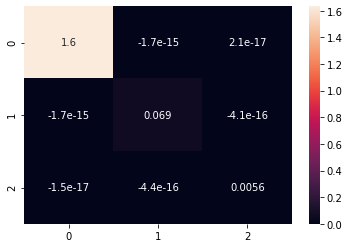

In [22]:
ax = sns.heatmap(Lambda_from_pca, annot=True)

Show the explained variances by each component (check with above)

In [23]:
print(100 * np.diag(Lambda_from_pca) / total_variance)
print('{:.6}% of total variance explained'.format(100 * np.sum(np.diag(Lambda_from_pca)) / total_variance))

[95.53366571  4.0667419   0.32890998]
99.9293% of total variance explained


Now perform the transformation of the covariance matrix using the decoder weights. Note that the matrix $\Lambda$ is no longer diagonal.

In [24]:
Lambda_from_decoder_weights = w2 @ C @ w2.T

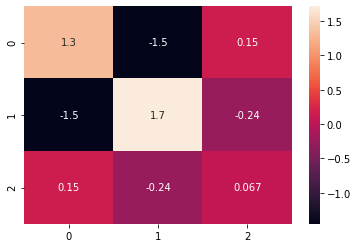

In [25]:
ax = sns.heatmap(Lambda_from_decoder_weights, annot=True)
plt.show()

Finally, perform the transformation of the covariance matrix using the left singular vectors of the decoder weights. 

In [26]:
Lambda_from_decoder_lsv = ae_decoder_lsv.T @ C @ ae_decoder_lsv

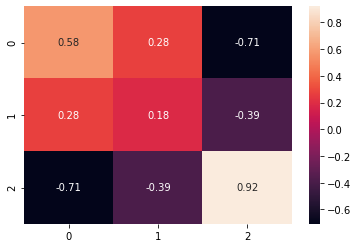

In [27]:
ax = sns.heatmap(Lambda_from_decoder_lsv, annot=True)
plt.show()

Show the explained variances by each diagonal component and compare with PCA.

In [28]:
print(100*np.diag(Lambda_from_decoder_lsv) / total_variance)
print('{:.6}% of total variance explained'.format(100*np.sum(np.diag(Lambda_from_decoder_lsv)) / total_variance))

[33.67590134 10.76882311 53.84830383]
98.293% of total variance explained


### Inspect the fit of the reconstructed data

First we get the reconstructed values from the trained model:

In [29]:
df_ae_recon = ae_model.predict(df.values)

Then we can plot the reconstructed values of each variable against its original value for every point. Differences introduced by the dimensionality reduction show up as deviation from the diagonal. 

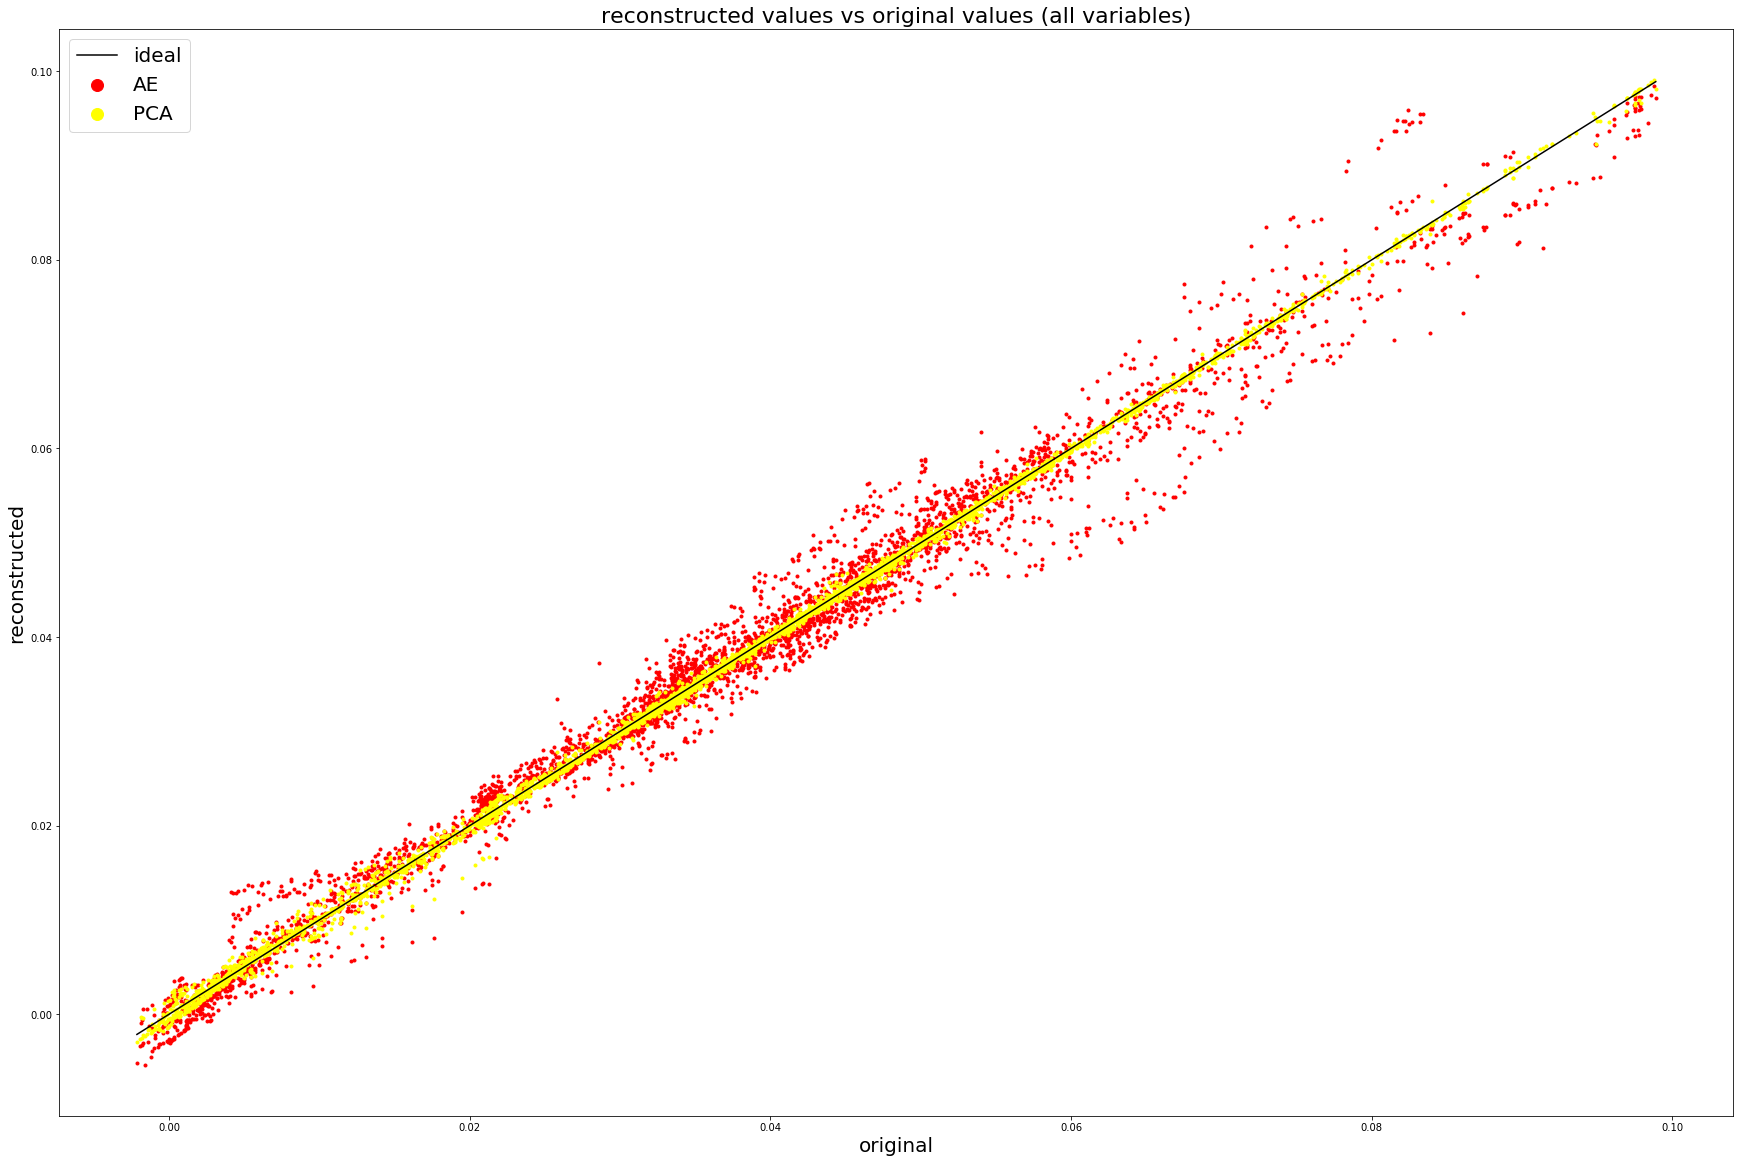

In [30]:
plt.figure(figsize=(30,20))
plt.title('reconstructed values vs original values (all variables)'
         , fontsize=22)
xy = np.linspace(df.values.min(), df.values.max(), 2)

plt.plot(xy, xy, c='black') # y = x
plt.scatter(df.values, df_ae_recon, marker='.', c='red') # ae recon vs original data
plt.scatter(df.values, df_pca_recon, marker='.', c='yellow') # pca preimage vs original data

plt.xlabel('original', fontsize=20)
plt.ylabel('reconstructed', fontsize=20)
plt.legend(['ideal', 'AE', 'PCA'], fontsize=20, markerscale=4);

## Visualize the data projected onto the principal components
First show the data on the principal components obtained by PCA. Then show the data using the left singular vectors from the decoder weight matrix.

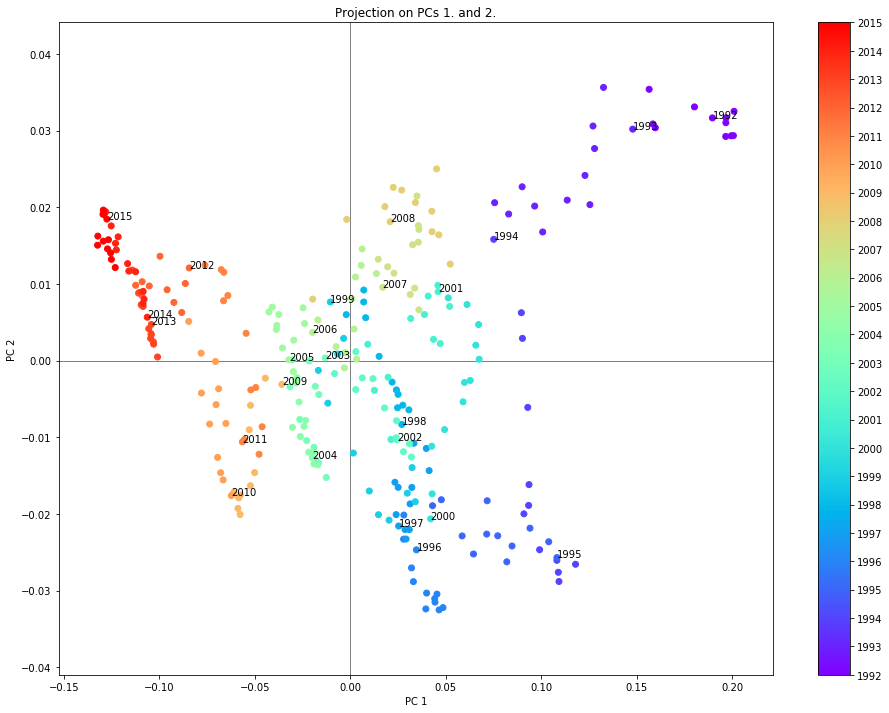

In [31]:
# you may set pc1 or pc2 to the integer index of any column in `df_pca`
pc1 = 0
pc2 = 1

merged_years = 1

fig = plt.figure(figsize=(16,12))
plt.title('Projection on PCs {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey",linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey",linewidth=1.0,zorder=0)
    
sc = plt.scatter(df_pca.loc[:, pc1], df_pca.loc[:, pc2], c = [d.year for d in df_pca.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_pca.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_pca.index])[::1])

for year in range(df_pca.index.min().year, df_pca.index.max().year+1, merged_years):
    year_start = df_pca.index[df_pca.index.searchsorted(datetime(year, 1, 1))]
    year_end = df_pca.index[df_pca.index.searchsorted(datetime(year + merged_years-1, 12, 31))]
    
    plt.annotate('{0}'.format(year), xy=(df_pca.loc[year_start, pc1],df_pca.loc[year_start, pc2]), 
                 xytext=(df_pca.loc[year_start,pc1],df_pca.loc[year_start,pc2]));


Now show the data using the left singular vectors from the decoder weight matrix. Note that the sign of the first principal component has been changed for ease of comparison.

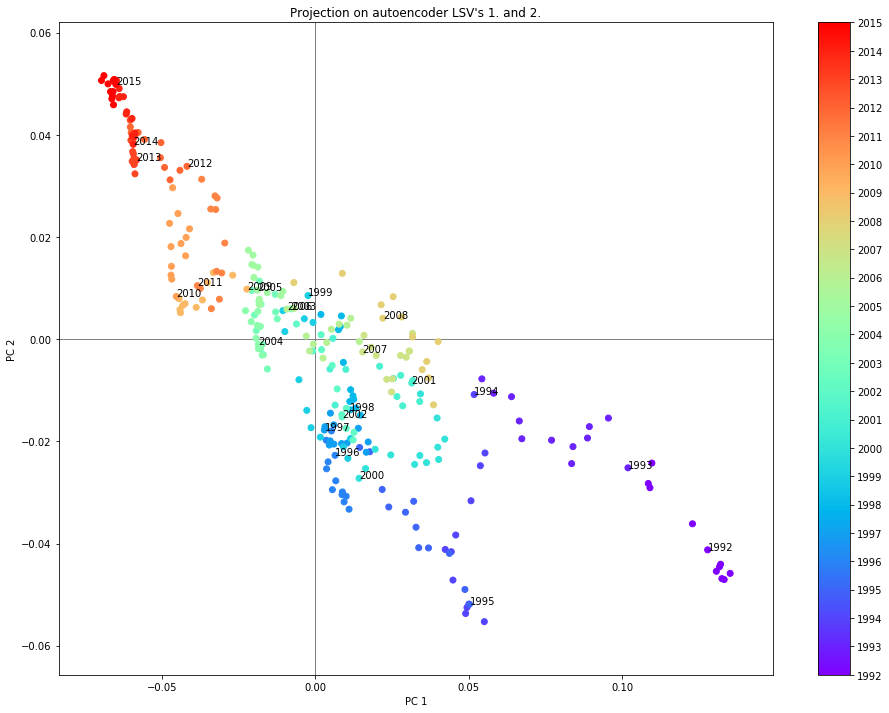

In [32]:
# you may set pc1 or pc2 to the integer index of any column in `df_ae`
pc1 = 0
pc2 = 1

merged_years = 1
fig = plt.figure(figsize=(16, 12))
plt.title('Projection on autoencoder LSV\'s {0}. and {1}.'.format(pc1+1,pc2+1))
plt.xlabel('PC '+str(pc1+1))
plt.ylabel('PC '+str(pc2+1))
plt.axhline(y=0,c="grey", linewidth=1.0,zorder=0)
plt.axvline(x=0,c="grey", linewidth=1.0,zorder=0)
    
sc = plt.scatter(-df_ae.loc[:,pc1], df_ae.loc[:,pc2], 
                 c=[d.year for d in df_ae.index], cmap='rainbow')
cb = plt.colorbar(sc)
cb.set_ticks(ticks=np.unique([d.year for d in df_ae.index])[::1])
cb.set_ticklabels(np.unique([d.year for d in df_ae.index])[::1])

for year in range(df_ae.index.min().year, df_ae.index.max().year+1, merged_years):
    year_start = df_ae.index[df_ae.index.searchsorted(datetime(year,1,1))]
    year_end = df_ae.index[df_ae.index.searchsorted(datetime(year+merged_years-1,12,31))]
    plt.annotate('{0}'.format(year), xy=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]), 
                 xytext=(-df_ae.loc[year_start,pc1],df_ae.loc[year_start,pc2]));

### Plot the reconstruction error of the linear autoencoder per variable

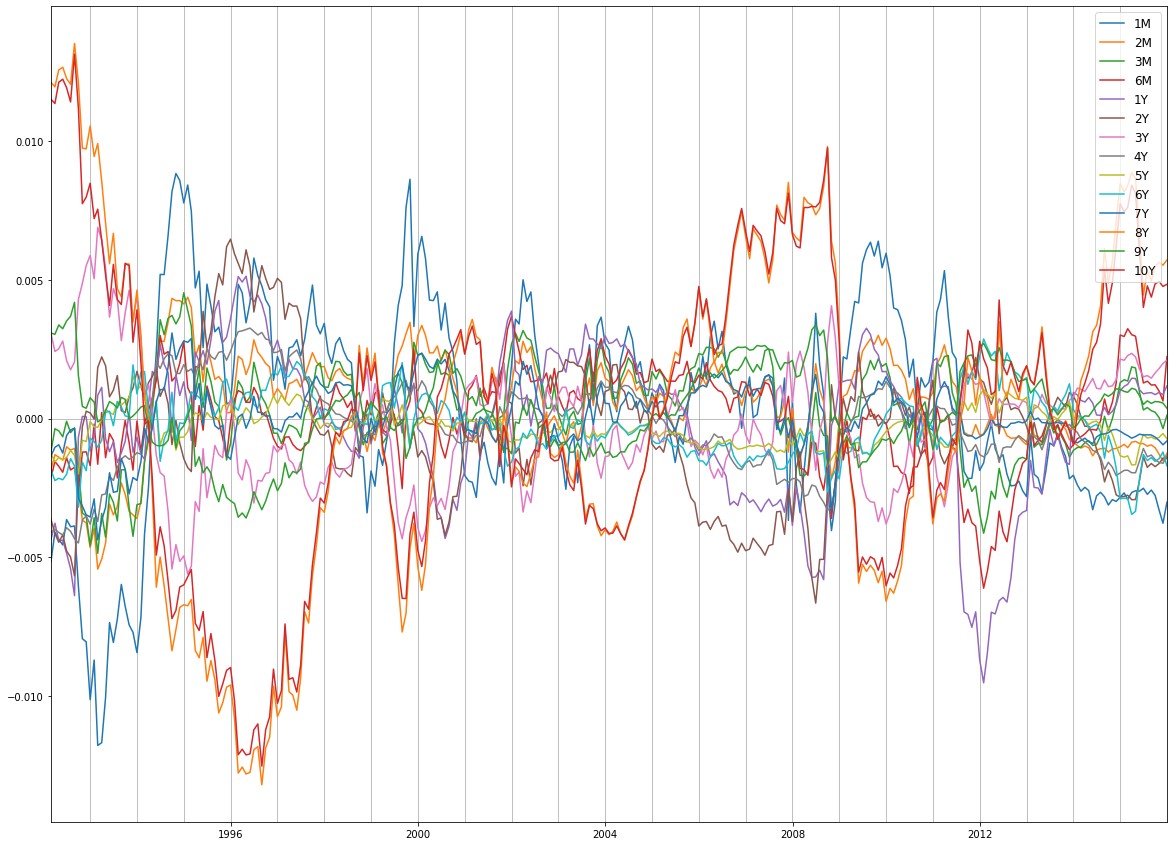

In [33]:
plt.figure(figsize=(20,15))
plt.plot(df.index, pd.DataFrame(df_ae_recon - df))
plt.legend(df.columns, fontsize=12, loc='upper right')
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0,c="grey",linewidth=0.5,zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i,1,1))-1],
                c="grey", linewidth=0.5, zorder=0)

## Deep Autoencoders

This nonlinear autoencoder architecture has two encoder and two decoder layers, each with the $tanh$ activation function. 

The first layer reduces the input to a set of `2*dimension` features, and the second halves this to `dimension`. 

The two decoder layers reverse this process, increasing the number of units in each layer first to half the original number of variables and then back into the input space.

In [34]:
def DeepAE(y, dimension, learning_rate = 1e-4, regularization = 5e-4, epochs=10):
    input = Input(shape=(y.shape[1],))
    encoded1 = Dense(np.int(2*dimension), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(input)
    encoded2 = Dense(dimension, activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded1)
    decoded1 = Dense(np.int(y.shape[1]/2), activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(encoded2)
    decoded2 = Dense(y.shape[1], activation='tanh',
                    kernel_regularizer=regularizers.l2(regularization))(decoded1)
    
    autoencoder = models.Model(input, decoded2)
    autoencoder.compile(optimizer=optimizers.adam(lr=learning_rate), loss='mean_squared_error')
    
    autoencoder.fit(y, y, epochs=epochs, batch_size=4, shuffle=True)
    
    return autoencoder

In [35]:
deepAE_model = DeepAE(df, 3, regularization=0, epochs=200)

Epoch 1/200
287/287 [==============================] - 2s 6ms/step - loss: 0.0019
Epoch 2/200
287/287 [==============================] - 0s 825us/step - loss: 0.0012
Epoch 3/200
287/287 [==============================] - 0s 818us/step - loss: 8.8549e-04
Epoch 4/200
287/287 [==============================] - 0s 786us/step - loss: 6.9072e-04
Epoch 5/200
287/287 [==============================] - 0s 798us/step - loss: 5.7005e-04
Epoch 6/200
287/287 [==============================] - 0s 787us/step - loss: 4.9323e-04
Epoch 7/200
287/287 [==============================] - 0s 804us/step - loss: 4.4331e-04
Epoch 8/200
287/287 [==============================] - 0s 938us/step - loss: 4.0735e-04
Epoch 9/200
287/287 [==============================] - 0s 787us/step - loss: 3.8041e-04
Epoch 10/200
287/287 [==============================] - 0s 823us/step - loss: 3.5908e-04
Epoch 11/200
287/287 [==============================] - 0s 843us/step - loss: 3.3863e-04
Epoch 12/200
287/287 [==================

287/287 [==============================] - 0s 811us/step - loss: 1.7830e-05
Epoch 94/200
287/287 [==============================] - 0s 803us/step - loss: 1.7722e-05
Epoch 95/200
287/287 [==============================] - 0s 800us/step - loss: 1.7556e-05
Epoch 96/200
287/287 [==============================] - 0s 1ms/step - loss: 1.7481e-05
Epoch 97/200
287/287 [==============================] - 0s 1ms/step - loss: 1.7447e-05
Epoch 98/200
287/287 [==============================] - 0s 827us/step - loss: 1.7359e-05
Epoch 99/200
287/287 [==============================] - 0s 803us/step - loss: 1.7297e-05
Epoch 100/200
287/287 [==============================] - 0s 837us/step - loss: 1.7226e-05
Epoch 101/200
287/287 [==============================] - 0s 802us/step - loss: 1.6951e-05
Epoch 102/200
287/287 [==============================] - 0s 819us/step - loss: 1.7285e-05
Epoch 103/200
287/287 [==============================] - 0s 799us/step - loss: 1.7083e-05
Epoch 104/200
287/287 [===========

287/287 [==============================] - 0s 829us/step - loss: 7.3912e-06
Epoch 185/200
287/287 [==============================] - 0s 805us/step - loss: 7.3833e-06
Epoch 186/200
287/287 [==============================] - 0s 801us/step - loss: 7.2718e-06
Epoch 187/200
287/287 [==============================] - 0s 820us/step - loss: 7.1454e-06
Epoch 188/200
287/287 [==============================] - 0s 796us/step - loss: 6.9073e-06
Epoch 189/200
287/287 [==============================] - 0s 859us/step - loss: 6.8379e-06
Epoch 190/200
287/287 [==============================] - 0s 805us/step - loss: 6.7105e-06
Epoch 191/200
287/287 [==============================] - 0s 810us/step - loss: 6.5484e-06
Epoch 192/200
287/287 [==============================] - 0s 826us/step - loss: 6.4210e-06
Epoch 193/200
287/287 [==============================] - 0s 824us/step - loss: 6.3602e-06
Epoch 194/200
287/287 [==============================] - 0s 806us/step - loss: 6.2546e-06
Epoch 195/200
287/287 [=

### Plot the reconstruction error of the deep autoencoder per variable

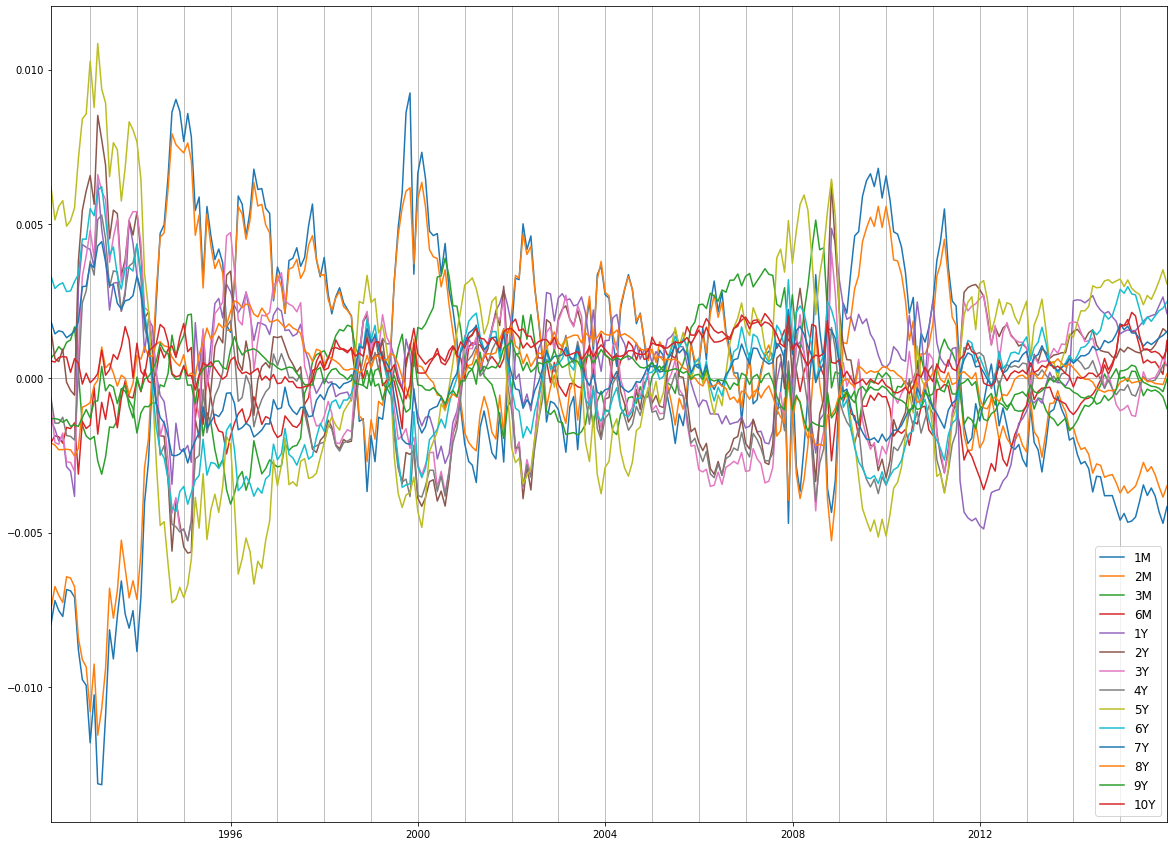

In [36]:
df_deep_recon = deepAE_model.predict(df)

plt.figure(figsize=(20, 15))
plt.plot(df.index, pd.DataFrame(df_deep_recon - df))
plt.xlim(df.index.min(), df.index.max())
plt.legend(df.columns, fontsize=12)
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)

### Compare reconstruction errors for Linear AE, Deep AE, and PCA

The reconstruction error is the orthogonal distance between the original datapoint and the subspace:

In [37]:
pca_rec_errs = np.sqrt(np.sum((df_pca_recon - df)**2, axis=1))

ae_rec_errs = np.sqrt(np.sum((df_ae_recon - df)**2, axis=1))

deep_rec_errs = np.sqrt(np.sum((df_deep_recon - df)**2, axis=1))

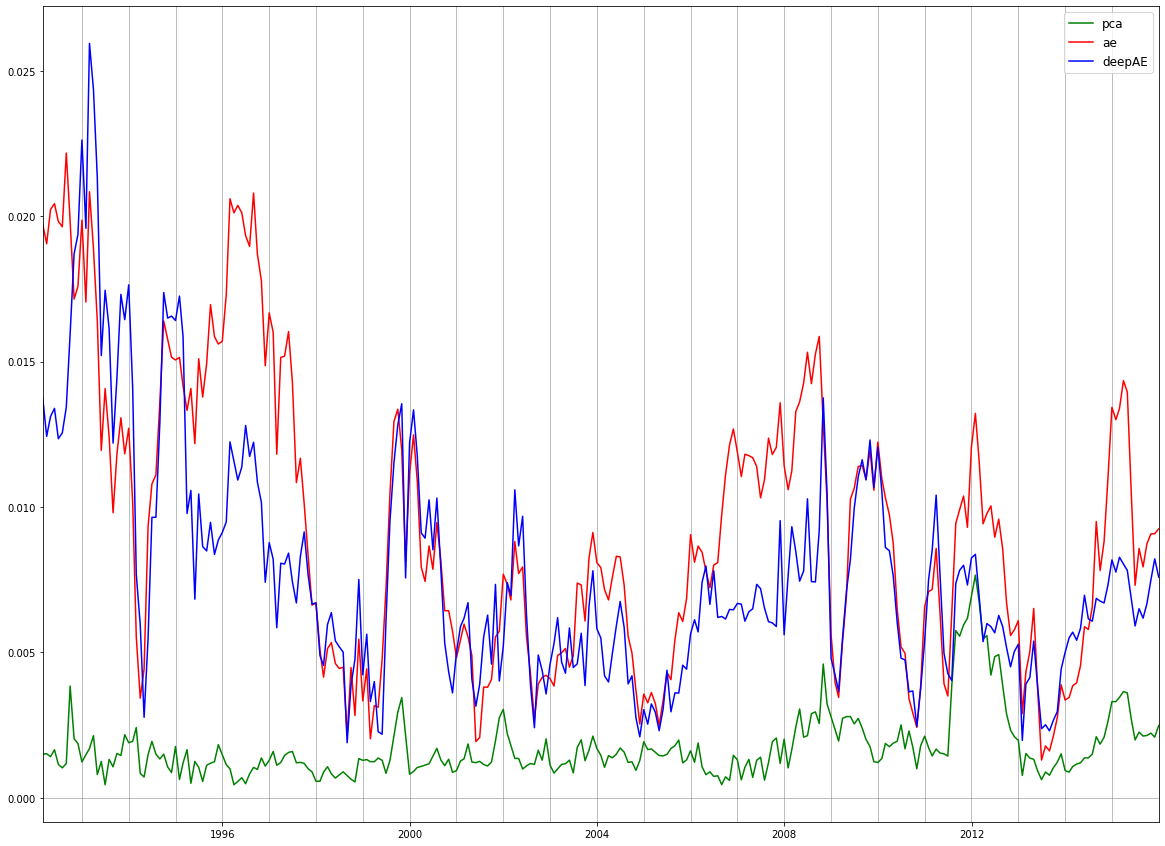

In [38]:
plt.figure(figsize=(20, 15))
plt.plot(df.index, pca_rec_errs, c='green')
plt.plot(df.index, ae_rec_errs, c='red')
plt.plot(df.index, deep_rec_errs, c='blue')
plt.legend(['pca','ae','deepAE'], fontsize=12)
plt.xlim(df.index.min(), df.index.max())
plt.axhline(y=0, c="grey", linewidth=0.5, zorder=0)
for i in range(df.index.min().year, df.index.max().year+1):
    plt.axvline(x=df.index[df.index.searchsorted(datetime(i, 1, 1)) - 1],
                c="grey", linewidth=0.5, zorder=0)